# Variational Quantum Regression to fit Parton Density Functions

## 1. From classical ML to quantum ML

> In the following we refer to supervised machine learning theory.

When dealing with a ML problem we typically need:
1. A parameteric model $\mathcal{M}$;
2. A way to embed input data $x$ into $\mathcal{M}$;
3. A predictor for estimating the output $y$;
4. A loss function $J$;
5. An optimizer $\mathcal{O}$.

In the following problem we are going to use Quantum Computing tools as interpeters
of the previous bullet points, building a Quantum Machine Learning (QML) [1-3] algorithm. 

<img src="figures/qml.png" width="600" height="600" align="center"/>

In particular:
1. we use a variational quantum circuit $C$ as $\mathcal{M}$;
2. we encode data into the circuit setting them as rotational angles in $RY$ and 
   $RZ$ gates following the procedure purposed in [4];
3. we use the expected value of a target Z observable as predictor: $$ y_{\rm est} = \langle 0 | C(x|\vec{\theta})^{\dagger} Z C(x|\vec{\theta}) | 0 \rangle. $$ 
4. we use a Mean-Squared Error (MSE) loss function, since we tackle a supervised ML
   problem: $$J_{\rm mse} = \frac{1}{N_{\rm data}} \sum_j \bigl[ y_{j,\rm meas} - y_{j, \rm est} \bigr]^2.$$
5. we build an Adam descent using the parameter shift rule [5-7].

#### Some imports

In [10]:
# to reload a module after modifications without restarting kernel
from importlib import reload
# to clear cell's output
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

# our version of a quantum regressor
import qpdf_scripts.vqregressor as vqr
from qibo import set_backend

set_backend("numpy")

[Qibo 0.1.15|INFO|2023-07-21 17:14:14]: Using numpy backend on /CPU:0


## 2. A look to the targets

We are going to tackle two different targets:
1. a dummy trigonometric functions to see how the vqr works;
2. one of the eight flavours of the proton PDF.

In [2]:
def plot_target(x, y, label, xscale="linear"):
    """Plot target function to be fitted"""
    plt.figure(figsize=(8,5))
    plt.title(label)
    plt.plot(x, y, color="purple", alpha=0.7, lw=2)
    plt.plot(x, y, color="purple", alpha=0.4, marker='.', markersize=12, ls='')
    plt.xlabel("y")
    plt.ylabel("x")
    plt.xscale(xscale)
    plt.grid(True)
    plt.show()

### 2.1 Dummy trigonometric function

The first target is the following trigonometric function:
$$ y = 2x + \sin(8x) - \cos(3x)^2, $$
then normalised to have $[0,1]$ as co-domain.

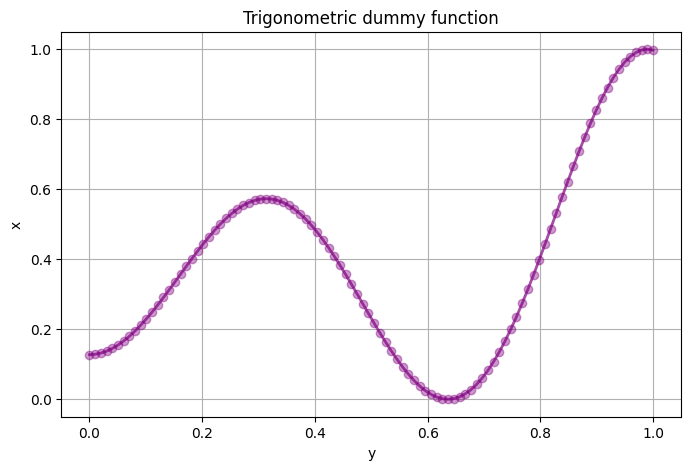

In [3]:
# trigonometric target
trig_target_x = np.linspace(0,1,100)
trig_target_y = 2*trig_target_x * np.sin(8*trig_target_x) - np.cos(3*trig_target_x)**2
# we use a <Z> as predictor, which is defined in [-1,1]
# for simplicity we use the range [0,1]
trig_target_y = (trig_target_y - np.min(trig_target_y)) / (np.max(trig_target_y)- np.min(trig_target_y))
plot_target(trig_target_x, trig_target_y, label="Trigonometric dummy function")

### 2.2 $u$ quark PDF

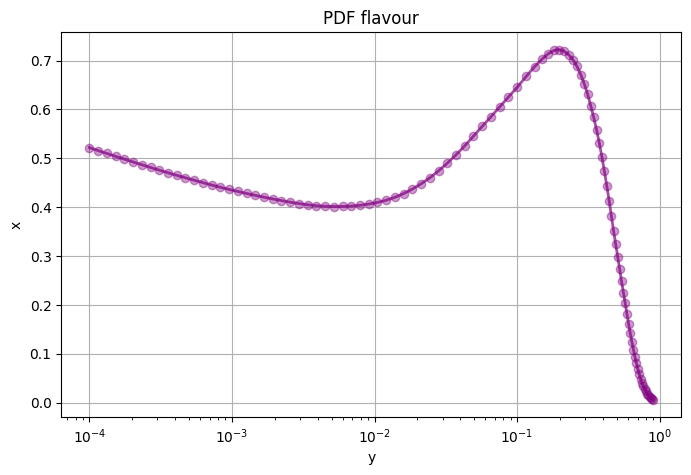

In [4]:
# HEP target
flav = 11
hep_data = np.loadtxt("data/qpdf_data/8flavours.dat")
hep_x = hep_data.T[0]
hep_y = hep_data.T[flav]
plot_target(hep_x, hep_y, label="PDF flavour", xscale="log")

## 3. Training of the VQR to fit the trigonometric function

A Variational Quantum Regressor can be found in `qpdf_scripts/vqregressor.py`. Before using it, we have a look to the class.

In [42]:
# initialize the regressor
regressor = vqr.VQRegressor(data=trig_target_x, labels=trig_target_y, layers=3, nqubits=1)

q0: ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─M─


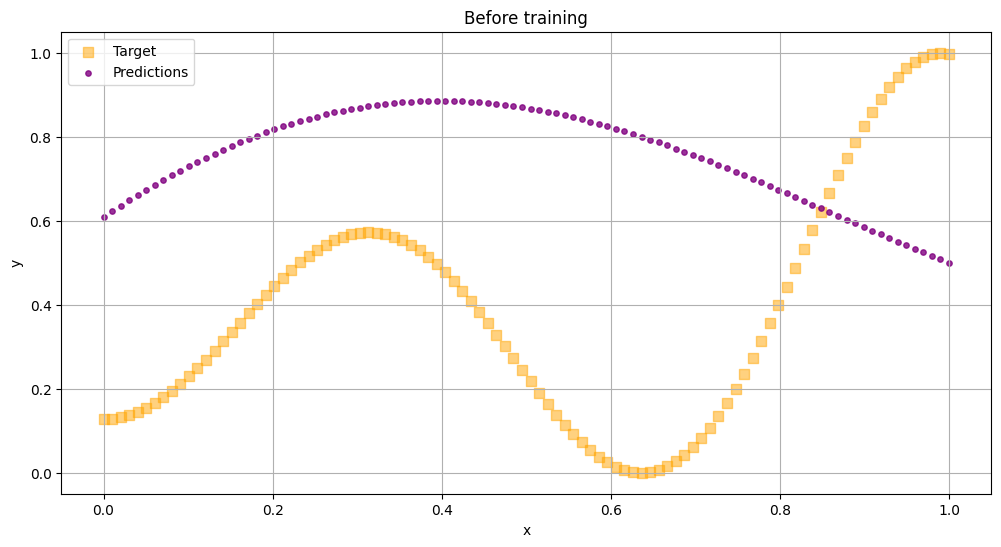

In [43]:
# show initial - not trained - predictions
regressor.show_predictions("Before training", xscale="linear")

In [44]:
# execute the training
history = regressor.gradient_descent(
    learning_rate=0.1,
    epochs=250,
    live_plotting=True
)

# clear output after the execution
clear_output()

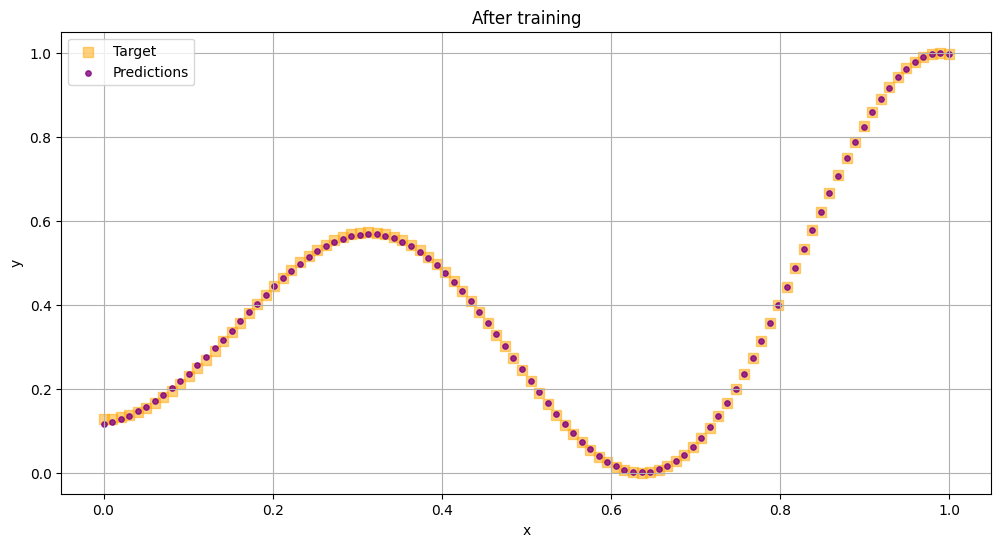

In [45]:
regressor.show_predictions("After training", xscale="linear")

### A look to the loss function history

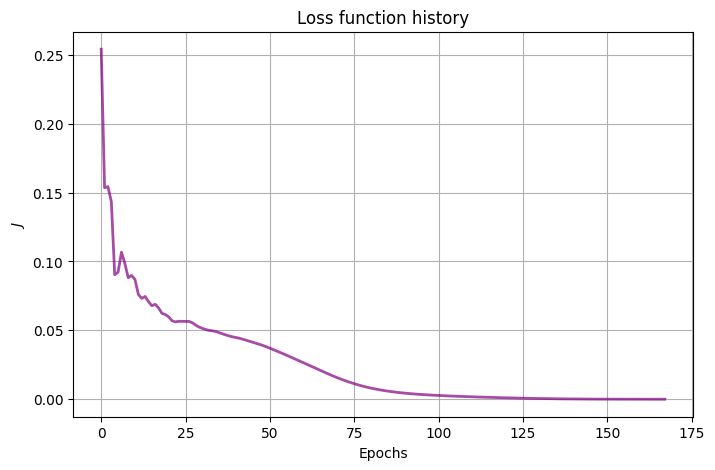

In [46]:
plt.figure(figsize=(8,5))
plt.title("Loss function history")
plt.plot(history, lw=2, color='purple', alpha=0.7)
plt.xlabel('Epochs')
plt.ylabel(r"$J$")
plt.grid(True)
plt.show()

## 4. Exercise: fitting a PDF
The second target is a proton PDF. In order to fit it, we are going to follow 
the ansatz introduced in [8].
Modify the ansatz of `vqregressor.VQRegressor` in order to follow the one presented 
in Ref. [8], thus perform a regression using the code. 


In [47]:
# reload the VQR module after your modifications
reload(vqr)

<module 'qpdf_scripts.vqregressor' from '/home/matteo/Documents/PhD/como-2023/w2t3-qml/qpdf_scripts/vqregressor.py'>

In [39]:
regressor = vqr.VQRegressor(data=hep_x, labels=hep_y, layers=5, nqubits=1)

q0: ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─RY─RY─RZ─RZ─M─


In [ ]:
regressor.show_predictions("Before training", xscale="log")

In [ ]:
history = regressor.gradient_descent(
    learning_rate=0.15,
    epochs=250,
    live_plotting=True
)

clear_output()

In [ ]:
regressor.show_predictions("After training", xscale="log")

### References

[1] [_An introduction to quantum machine learning_, 2014](https://arxiv.org/abs/1409.3097)

[2] [_Quantum Machine Learning_, 2016](https://arxiv.org/abs/1611.09347)

[3] [_Quantum Algorithm for Linear Regression_, 2014](https://arxiv.org/abs/1402.0660)

[4] [_Data re-uploading for a universal quantum classifier_, 2020](https://arxiv.org/abs/1907.02085)

[5] [_Stochastic gradient descent for hybrid quantum-classical optimization_, 2021](https://arxiv.org/abs/1910.01155)

[6] [_Adam: A Method for Stochastic Optimization_, 2014](https://arxiv.org/abs/1412.6980)

[7] [_A quantum analytical Adam descent through parameter shift rule using Qibo_, 2022](https://arxiv.org/abs/2210.10787)

[8] [_Determining the proton content with a quantum computer_, 2021](https://arxiv.org/abs/2011.13934)